## Helicopter Basic Hover Performance

This notebook applies the general equation for induced velocity, and the related performance coefficients, to evaluate hover performance.

In [37]:
###   Imports and Logging   ###
import sys
import logging
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import __version__ as pltver
import matplotlib.ticker as ticker
from skaero.atmosphere import coesa
from skaero import __version__ as skver


logging.basicConfig(
    level=logging.DEBUG,
    format=' %(asctime)s -  %(levelname)s -  %(message)s'
)

logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Python version: {}'.format(sys.version))
logging.info('Author: Benjamin Crews')
logging.info('Numpy version: {}'.format(np.version.version))
logging.info('Pandas version: {}'.format(pd.__version__))
logging.info('Matplotlib version: {}'.format(pltver))
logging.info('SciKit-Aero version: {}'.format(skver))
logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

 2020-02-09 17:36:53,562 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 2020-02-09 17:36:53,563 -  INFO -  Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
 2020-02-09 17:36:53,563 -  INFO -  Author: Benjamin Crews
 2020-02-09 17:36:53,564 -  INFO -  Numpy version: 1.16.2
 2020-02-09 17:36:53,564 -  INFO -  Pandas version: 0.24.2
 2020-02-09 17:36:53,565 -  INFO -  Matplotlib version: 3.0.3
 2020-02-09 17:36:53,565 -  INFO -  SciKit-Aero version: 0.1
 2020-02-09 17:36:53,566 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [25]:
###   Functions   ###
def mom_Theory_vi(T: float, rho: float, A: float):
    '''
    Calculates the total induced velocity of an actuator disk, using
    Momentum theory.
    
    Ensure consistent units are used!
    '''
    return math.sqrt(T/(2*rho*A))


def phi_tip(vi: float, V: float, Omega: float, R: float):
    '''
    Calculates the inflow angle, using an induced velocity, climb rate,
    and tip speed.
    
    Ensure consistent units are used!
    '''
    return (vi + V)/(Omega*R)


def thrust_Ct_mom(T: float,
                  R: float,
                  rho: float,
                  Omega: float
                 ) -> float:
    '''
    Calculates the thrust coefficient based on momentum theory.
    
    Ensure consistend units are used!
    '''
    return T/(math.pi*R**2*rho*(Omega*R)**2)


# def thrust_Ct_blade(sol: float, theta_tip: float, phi_tip: float):
#     '''
#     Calculates the thrust coefficient, given the solidity, blade angle,
#     and inflow angle. (blade-element method)
    
#     Ensure consistent units are used!
#     '''
#     return 0.25*sol*(theta_tip - phi_tip)


def theta_tip_ideal(Ct: float, sol: float, a: float, phi_tip: float) -> float:
    '''
    Calculates the tip blade angle for an ideally-twisted, constant-chord blade.
    
    Ensure consistend units are used!
    '''
    return (Ct*4/(sol*a) + phi_tip)


def local_solidity(b: int,
                   c: float,
                   x: float,
                   R: float
                  ):
    '''
    Calculates the local solidity at blade station 'x' based on the blade geometry.
    '''
    # TODO: Lookup local chord based on x and chord function definition.
    # (c: function instead of c: float)
    return b*c/(math.pi*R)


def vel_i(Ohm: float,
          solidity_x: float,
          theta: float,
          R: float,
          x: float,
          a: float = 2*math.pi,
          V: float = 0,
         ):
    '''
    This function calculates the induced velocity, based on design parameters.
    Ensure that consistent units are used!
    '''
    c1 = V/2
    c2 = (solidity_x*a*Ohm*R)/16
    c3 = c1 + c2
    
    c4 = 2*(theta*x*Ohm*R - V)
    c5 = (4*V**2)/(solidity_x*a*Ohm*R)
    c6 = (solidity_x*a*Ohm*R)/16
    
    v = c3*(-1 + math.sqrt(1 + (c4/(c5 + V + c6)) ) )
    
    return v

def linear_twist(x, theta_t: float, twist_rate: int = -12):
    '''
    Provides the theta for the blade element,
    defaulted on a 12 degree linear twist.
    '''
    return (twist_rate*(x - 1) + theta_t)

In [42]:
## Problem Definition (from lecture 7 example)

THRUST = 5000      # [lbs], Starting thrust value
BLADES = 4         # []
DIAMETER = 35      # [ft]
R = DIAMETER/2     # [ft]
CHORD = 10.4/12    # [ft]    ; from the example in lecture 7
Ohm = 756/R        # [rad/s] ; from the example in lecture 7

atm = coesa.table(0) # an atmosphere at 0 height
rho = atm[3]/515   # [slugs/ft3] ; coesa returns rho in SI units

sol = local_solidity(b=BLADES, c=CHORD, x=1, R=R)

In [43]:
## For an ideal twist, what is the induced velocity and blade angle?

theta = theta_tip_ideal(thrust_Ct_mom(THRUST, R, rho, Ohm),                               # The Ct from mom. theory
                        sol,                                                              # Solidity
                        2*math.pi,                                                        # Lift curve slope
                        phi_tip(vi = mom_Theory_vi(T=THRUST, rho=rho, A=math.pi*R**2),    # Inflow angle, based on momentum theory
                                V = 0,
                                Omega = Ohm,
                                R = R
                               )
                       )

print('From Momentum Theory alone: v_avg = {:.5}'.format(mom_Theory_vi(T=5000,
                                                         rho=rho,
                                                         A=math.pi*R**2)
                                                        )
     )

vi = vel_i(Ohm = Ohm,
      solidity_x = sol,
      theta = theta,
      R = R,
      x = 1,
     )


print('Solidity = {:.3}'.format(sol))
print('Theta = {:.5f} ({:.5f} degrees)'.format(theta, math.degrees(theta)))
print('Induced velocity = {:.5}'.format(vi))
print('Since an ideal twist is used, velocity is the same along the blade!')

From Momentum Theory alone: v_avg = 33.052
Solidity = 0.0631
Theta = 0.08231 (4.71623 degrees)
Induced velocity = 33.052
Since an ideal twist is used, velocity is the same along the blade!


In [44]:
x = np.linspace(0.01, 1, num=15)
print('x range = {}\n'.format(x))

theta = np.deg2rad(linear_twist(x, 9.998))                                        # 9.998 degrees comes from iterating to find a blade-
print('Twist = {}\n'.format(theta))                                               # element Ct that matches the Thrust. (from lecture 7 example)

# Use the thrust coefficient from Momemtum theory
# to derive the tip blade angle
theta_tip_ideal(thrust_Ct_mom(THRUST, R, rho, Ohm),                               # The Ct from mom. theory
                sol,                                                              # Solidity
                2*math.pi,                                                        # Lift curve slope
                phi_tip(vi = mom_Theory_vi(T=THRUST, rho=rho, A=math.pi*R**2),    # Inflow angle, based on momentum theory
                        V = 0,
                        Omega = Ohm,
                        R = R
                       )
               )         
vi = []

for i,sta in enumerate(x):
#     logging.debug('Index: {}'.format(i))
#     logging.debug('Station: {:.5}'.format(sta))
#     logging.debug('Blade angle: {:.3}'.format(theta[i]))
    vi.append(-vel_i(Ohm, sol, theta[i], R, sta))

print('Induced velocity = {}'.format(vi))

x range = [0.01       0.08071429 0.15142857 0.22214286 0.29285714 0.36357143
 0.43428571 0.505      0.57571429 0.64642857 0.71714286 0.78785714
 0.85857143 0.92928571 1.        ]

Twist = [0.38184313 0.36703277 0.3522224  0.33741204 0.32260167 0.30779131
 0.29298094 0.27817058 0.26336021 0.24854985 0.23373948 0.21892911
 0.20411875 0.18930838 0.17449802]

Induced velocity = [-2.693026978291261, -15.761260880135827, -24.40899060854734, -30.998961789819848, -36.27593933664732, -40.59141860636988, -44.14372771477292, -47.056629579292085, -49.41218466292504, -51.26669178202137, -52.659214886111066, -53.616439368003206, -54.1555202701237, -54.28572101115667, -54.009237570551335]


 2020-02-09 17:57:22,376 -  DEBUG -  update_title_pos
 2020-02-09 17:57:22,549 -  DEBUG -  update_title_pos
 2020-02-09 17:57:22,703 -  DEBUG -  update_title_pos
 2020-02-09 17:57:22,772 -  DEBUG -  update_title_pos
 2020-02-09 17:57:22,822 -  DEBUG -  update_title_pos


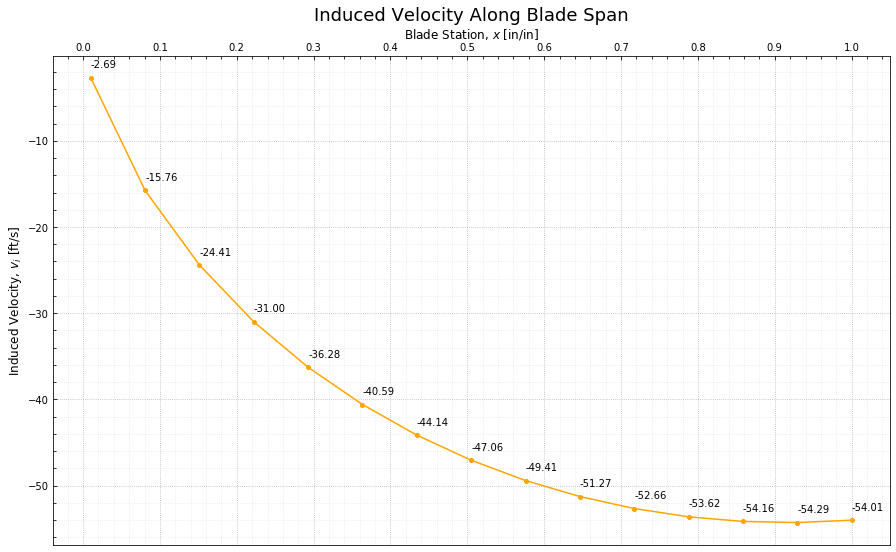

In [49]:
## This cell just plots the induced velocity

fig, ax = plt.subplots(figsize=(15,9))

# Add the data and color it
ax.plot(x, vi, color='orange', marker='o', markersize='4')

# Axis labels
ax.set_xlabel('Blade Station, $x$ [in/in]', fontsize=12)
ax.set_ylabel('Induced Velocity, $v_i$ [ft/s]', fontsize=12)
ax.set_title('Induced Velocity Along Blade Span', fontsize=18)

# Move the axis and its label to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Set the ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
ax.tick_params(which='minor', width=0.75, length=2.5)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='both', direction='in')

# Set the grid lines
ax.grid(b=True, which='major', linestyle=':')
ax.grid(b=True, which='minor', linestyle=':', alpha=0.3)

# Set the data labels
for x_sta,y in zip(x, vi):
    label = '{:.2f}'.format(y)
    ax.annotate(label,
                (x_sta,y),
                textcoords='offset points',
                xytext=(0,10),
                ha='left'
                )